In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import warnings

# Настройка графиков и предупреждений
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


Загрузка и изучение данных

In [2]:
# Загрузка данных
train = pd.read_csv('flight_delays_train.csv')  
test = pd.read_csv('flight_delays_test.csv')    

# Просмотр структуры данных
print("Train dataset info:")
print(train.info())
print("Test dataset info:")
print(test.info())

# Первые строки данных
print(train.head())
print(test.head())


Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB
None
Test dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 n

Анализ данных

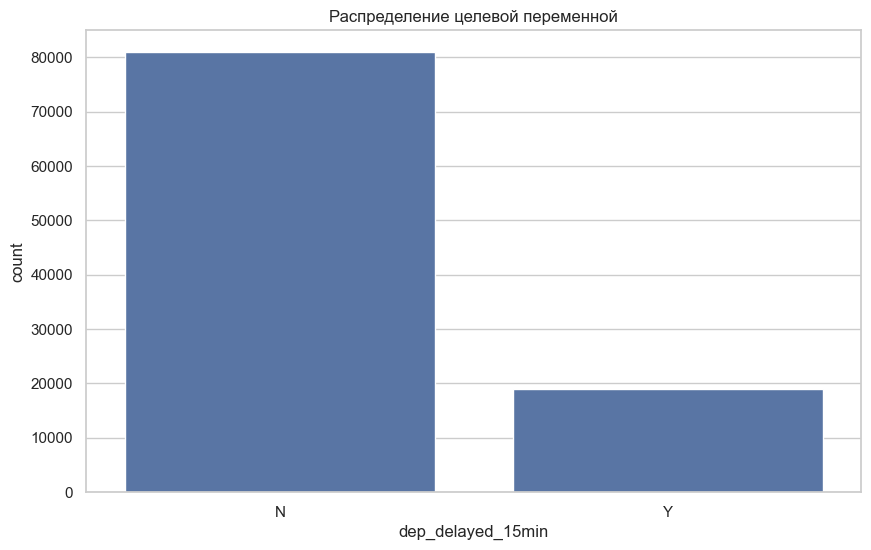

Доля рейсов с задержкой: dep_delayed_15min
N    0.80956
Y    0.19044
Name: proportion, dtype: float64


In [3]:
# Распределение целевой переменной
sns.countplot(data=train, x='dep_delayed_15min')
plt.title('Распределение целевой переменной')
plt.show()

# Вывод доли задержек
print("Доля рейсов с задержкой:", train['dep_delayed_15min'].value_counts(normalize=True))


             DepTime      Distance
count  100000.000000  100000.00000
mean     1341.523880     729.39716
std       476.378445     574.61686
min         1.000000      30.00000
25%       931.000000     317.00000
50%      1330.000000     575.00000
75%      1733.000000     957.00000
max      2534.000000    4962.00000


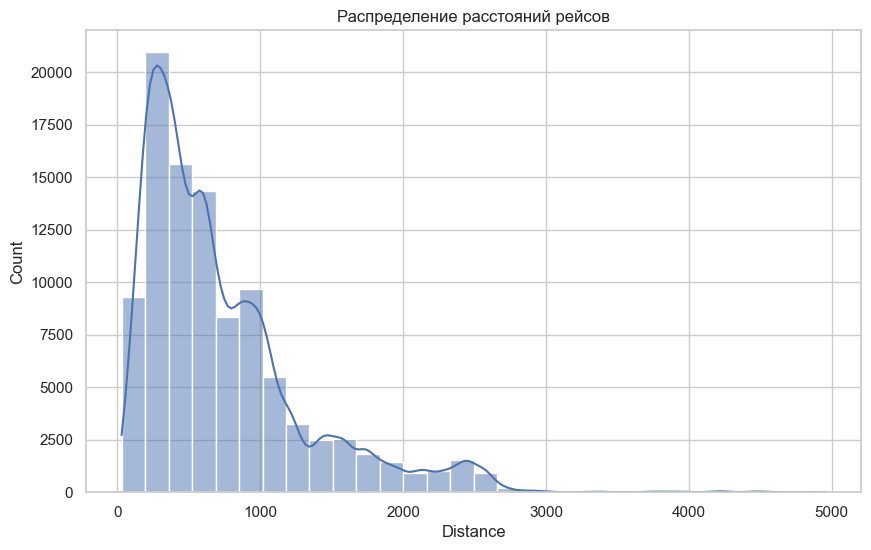

In [4]:
# Статистика числовых признаков
print(train.describe())

# Распределение расстояний (Distance)
sns.histplot(train['Distance'], bins=30, kde=True)
plt.title('Распределение расстояний рейсов')
plt.show()


Предобработка данных

In [5]:
# Замена 'Y' и 'N' на 1 и 0
train['dep_delayed_15min'] = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})


In [9]:
# Категориальные признаки
cat_columns = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']

for col in cat_columns:
    # Преобразуем все значения в строковый тип
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    
    # Объединяем данные из train и test для учета всех категорий
    all_data = pd.concat([train[col], test[col]], axis=0)
    
    # Применяем LabelEncoder
    le = LabelEncoder()
    le.fit(all_data)
    
    # Трансформируем данные
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])


In [10]:
scaler = StandardScaler()
train['Distance'] = scaler.fit_transform(train[['Distance']])
test['Distance'] = scaler.transform(test[['Distance']])


In [12]:
# Разделяем данные на X (признаки) и y (целевая переменная)
X = train.drop(columns=['dep_delayed_15min'])
y = train['dep_delayed_15min']

# Делим данные на тренировочную и валидационную выборки

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")


Размер тренировочной выборки: (80000, 8)
Размер валидационной выборки: (20000, 8)


Случайный лес

In [13]:
# Модель случайного леса
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)

# Предсказания на валидационной выборке
y_pred_rf = rf.predict_proba(X_val)[:, 1]
roc_auc_rf = roc_auc_score(y_val, y_pred_rf)
print(f"ROC AUC для случайного леса: {roc_auc_rf:.4f}")


ROC AUC для случайного леса: 0.7211


XGBoost

In [14]:
# Модель XGBoost
xgb = XGBClassifier(random_state=42, n_estimators=100, max_depth=10, learning_rate=0.1)
xgb.fit(X_train, y_train)

# Предсказания на валидационной выборке
y_pred_xgb = xgb.predict_proba(X_val)[:, 1]
roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print(f"ROC AUC для XGBoost: {roc_auc_xgb:.4f}")


ROC AUC для XGBoost: 0.7503


Настройка гиперпараметров

In [15]:
# Параметры для настройки случайного леса
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Настройка гиперпараметров
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='roc_auc', cv=3)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Оценка на валидационной выборке
y_pred_best_rf = best_rf.predict_proba(X_val)[:, 1]
roc_auc_best_rf = roc_auc_score(y_val, y_pred_best_rf)
print(f"ROC AUC для оптимизированного случайного леса: {roc_auc_best_rf:.4f}")


Лучшие параметры: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
ROC AUC для оптимизированного случайного леса: 0.7394


In [17]:
print(test.columns)


Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance'],
      dtype='object')


Выбор лучшей модели и предсказания


In [18]:
# Выбор модели с наилучшим результатом
best_model = max([(rf, roc_auc_rf), (xgb, roc_auc_xgb), (best_rf, roc_auc_best_rf)], key=lambda x: x[1])[0]

# Предсказания на тестовом наборе
test_predictions = best_model.predict_proba(test)[:, 1]

# Формирование файла для сабмита
submission = pd.DataFrame({
    'id': range(1, len(test) + 1),  # Используем порядковые номера как идентификатор
    'dep_delayed_15min': test_predictions  # Предсказания
})

# Сохранение файла
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv готов.")


Файл submission.csv готов.


Визуализация результатов

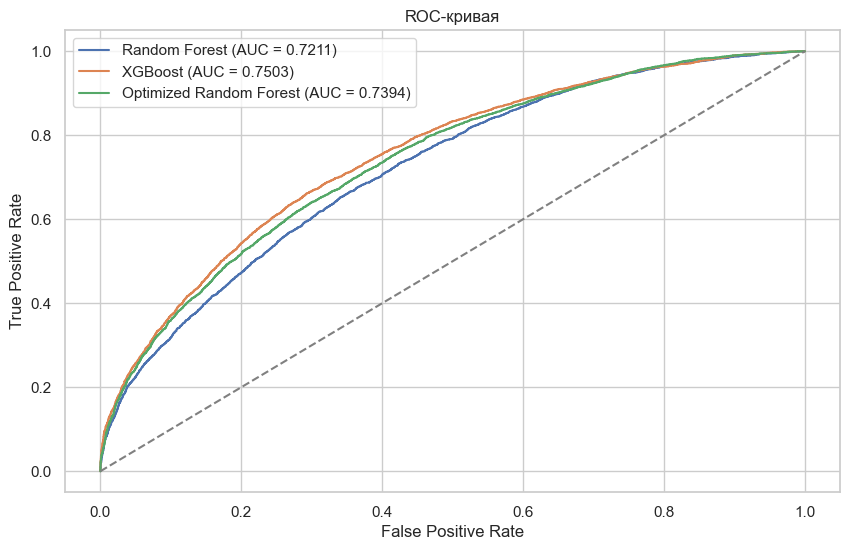

In [20]:
from sklearn.metrics import roc_curve

# ROC-кривая для случайного леса
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")

# ROC-кривая для XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})")

# ROC-кривая для оптимизированного случайного леса
y_pred_best_rf = best_rf.predict_proba(X_val)[:, 1]
fpr_best_rf, tpr_best_rf, _ = roc_curve(y_val, y_pred_best_rf)
plt.plot(fpr_best_rf, tpr_best_rf, label=f"Optimized Random Forest (AUC = {roc_auc_best_rf:.4f})")

# Общие настройки графика
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Линия случайного классификатора
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.show()
